![logo.png](https://github.com/interviewquery/takehomes/blob/amazon_1/amazon_1/logo.png?raw=1)

# Overview

You are selling certain items at your store. Every once in a while you may experience shortage. In which case, you notify your customers when your inventory will be replenished. You want to know which percent of your customers are not waiting for the replenishment and buying the item elsewhere - lost sales due to shortage. (Note that some do wait for your replenishment which is expressed as a higher demand at the day of replenishment).

![](https://cdn.mathpix.com/cropped/2022_09_14_28e45c346ad5b3be11fag-1.jpg?height=681&width=1632&top_left_y=527&top_left_x=252)

**How would you find that out?**

Simplifying assumptions:

1. The demand has no trend and no seasonality.

2. We may assume demand to follow the function $d_{t}=d_{t-1}+\varepsilon_{t}$, where $\varepsilon_{t}$ is the noise such that $\varepsilon_{t} \sim \mathcal{N}\left(0, \sigma^{2}\right)$. That is, the noise is symmetric and unbiased.

3. Customers experiencing shortage that decide to come back, would only come back on the day of replenishment.

4. Replenishment occurs in the beginning of days only.

5. Each customer buys no more than 1 item

In [1]:
!git clone --branch amazon_1 https://github.com/interviewquery/takehomes.git
%cd takehomes/amazon_1
!ls
!if [[ $(ls *.zip) ]]; then unzip *.zip; fi

Cloning into 'takehomes'...
remote: Enumerating objects: 1963, done.
remote: Counting objects: 100% (1963/1963), done.
remote: Compressing objects: 100% (1220/1220), done.
remote: Total 1963 (delta 752), reused 1927 (delta 726), pack-reused 0 (from 0)
Receiving objects: 100% (1963/1963), 297.43 MiB | 12.88 MiB/s, done.
Resolving deltas: 100% (752/752), done.
/content/takehomes/amazon_1
data.csv  logo.png  takehomefile.ipynb
ls: cannot access '*.zip': No such file or directory


In [2]:
! pwd

/content/takehomes/amazon_1


In [3]:
! ls

data.csv  logo.png  takehomefile.ipynb


In [27]:
import pandas as pd
import numpy as np
import plotly.express as px
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

In [5]:
df = pd.read_csv("data.csv")
df.head()

,date,inventory,sales
0,7/1/20,189,31
1,7/2/20,159,30
2,7/3/20,127,32
3,7/4/20,101,26
4,7/5/20,74,27


In [6]:
df.describe()

,inventory,sales
count,374.000000,374.000000
mean,453.839572,34.700535
std,290.941452,11.463950
min,0.000000,0.000000
25%,196.500000,27.000000
50%,450.500000,35.000000
75%,706.500000,42.000000
max,963.000000,79.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       374 non-null    object
 1   inventory  374 non-null    int64 
 2   sales      374 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 8.9+ KB


In [41]:
df["date"] = pd.to_datetime(df["date"])

In [24]:
df_melt = df.melt(id_vars=["date"], value_vars =["sales", "inventory"], var_name="metrics", value_name="count")
df_melt.head()

,date,metrics,count
0,2020-07-01,sales,31
1,2020-07-02,sales,30
2,2020-07-03,sales,32
3,2020-07-04,sales,26
4,2020-07-05,sales,27


In [25]:
px.line(df_long, x="date", y="value", color="metrics", title="Sales and Inventory Timeline")


In [35]:
# decompose sales data
result = seasonal_decompose(df["sales"], model="additive", period=7)

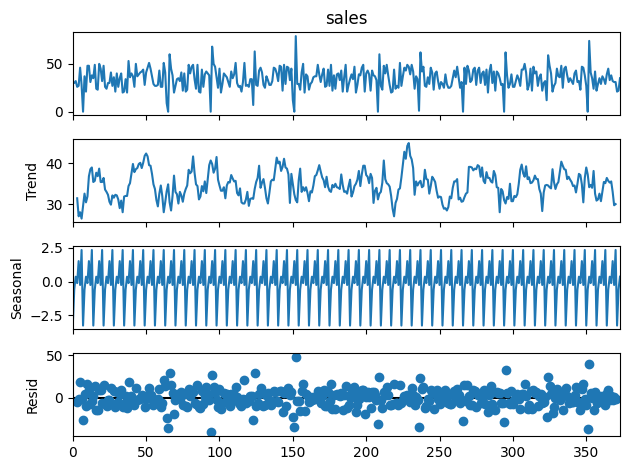

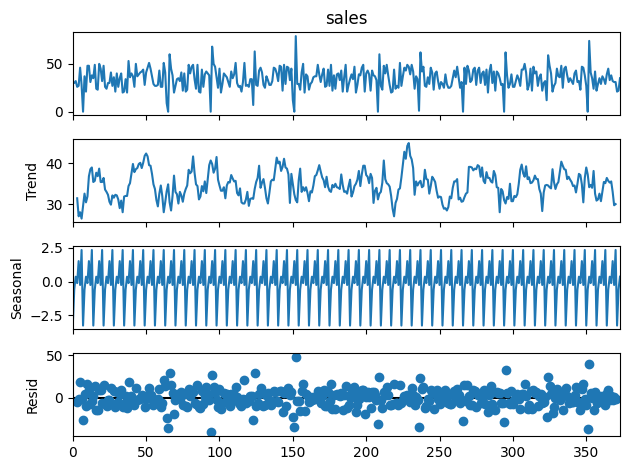

In [36]:
result.plot()

In [39]:
df["day"] = df["date"].apply(lambda x: x.day)
df["week"] = df["date"].apply(lambda x:x.week)
df["month"] = df["date"].apply(lambda x:x.month)
df.head()

,date,inventory,sales,day,week,month
0,2020-07-01,189,31,1,27,7
1,2020-07-02,159,30,2,27,7
2,2020-07-03,127,32,3,27,7
3,2020-07-04,101,26,4,27,7
4,2020-07-05,74,27,5,27,7


In [43]:
# prompt: map day to english names of the days

day_map = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday"
}

df["day_name"] = df["date"].dt.dayofweek.map(day_map)
df.head()

,date,inventory,sales,day,week,month,day_name
0,2020-07-01,189,31,1,27,7,Wednesday
1,2020-07-02,159,30,2,27,7,Thursday
2,2020-07-03,127,32,3,27,7,Friday
3,2020-07-04,101,26,4,27,7,Saturday
4,2020-07-05,74,27,5,27,7,Sunday


In [71]:
#Naive Forecast
df["expected_sales"] = df["sales"].shift(7)
df.head(10)

,date,inventory,sales,day,week,month,day_name,expected_sales,avg_sales
0,2020-07-01,189,31,1,27,7,Wednesday,NaN,31.0
1,2020-07-02,159,30,2,27,7,Thursday,NaN,34.0
2,2020-07-03,127,32,3,27,7,Friday,NaN,35.0
3,2020-07-04,101,26,4,27,7,Saturday,NaN,35.0
4,2020-07-05,74,27,5,27,7,Sunday,NaN,36.0
5,2020-07-06,28,46,6,28,7,Monday,NaN,34.0
6,2020-07-07,0,28,7,28,7,Tuesday,NaN,37.0
7,2020-07-08,0,0,8,28,7,Wednesday,31.0,31.0
8,2020-07-09,963,37,9,28,7,Thursday,30.0,34.0
9,2020-07-10,942,21,10,28,7,Friday,32.0,35.0


In [45]:
avg_sales_by_day = df.groupby("day_name")["sales"].mean()
avg_sales_by_day

,sales
day_name,
Friday,35.129630
Monday,34.471698
Saturday,34.660377
Sunday,36.264151
Thursday,33.981481
Tuesday,37.075472
Wednesday,31.388889


In [67]:
def return_avg_sale_by_day(day):
    return round(avg_sales_by_day[day],0)

In [68]:
return_avg_sale_by_day("Friday")

35.0

In [72]:
df.head()

,date,inventory,sales,day,week,month,day_name,expected_sales,avg_sales
0,2020-07-01,189,31,1,27,7,Wednesday,NaN,31.0
1,2020-07-02,159,30,2,27,7,Thursday,NaN,34.0
2,2020-07-03,127,32,3,27,7,Friday,NaN,35.0
3,2020-07-04,101,26,4,27,7,Saturday,NaN,35.0
4,2020-07-05,74,27,5,27,7,Sunday,NaN,36.0


In [73]:
df.fillna(0, inplace=True)
df.head()

,date,inventory,sales,day,week,month,day_name,expected_sales,avg_sales
0,2020-07-01,189,31,1,27,7,Wednesday,0.0,31.0
1,2020-07-02,159,30,2,27,7,Thursday,0.0,34.0
2,2020-07-03,127,32,3,27,7,Friday,0.0,35.0
3,2020-07-04,101,26,4,27,7,Saturday,0.0,35.0
4,2020-07-05,74,27,5,27,7,Sunday,0.0,36.0


In [74]:
df["avg_sales"] = df["day_name"].apply(return_avg_sale_by_day)
df.head()

,date,inventory,sales,day,week,month,day_name,expected_sales,avg_sales
0,2020-07-01,189,31,1,27,7,Wednesday,0.0,31.0
1,2020-07-02,159,30,2,27,7,Thursday,0.0,34.0
2,2020-07-03,127,32,3,27,7,Friday,0.0,35.0
3,2020-07-04,101,26,4,27,7,Saturday,0.0,35.0
4,2020-07-05,74,27,5,27,7,Sunday,0.0,36.0


In [75]:
df_melt = df.melt(id_vars=["date"], value_vars =["sales", "inventory", "expected_sales", "avg_sales"], var_name="metrics", value_name="count")
df_melt.head()

,date,metrics,count
0,2020-07-01,sales,31.0
1,2020-07-02,sales,30.0
2,2020-07-03,sales,32.0
3,2020-07-04,sales,26.0
4,2020-07-05,sales,27.0


In [77]:
px.line(df_melt, x= ["date"], y="count", color="metrics")

In [78]:
# prompt: generate a 95th percentile line for sales

# Calculate the 95th percentile of sales
percentile_95 = np.percentile(df['sales'], 95)

# Print the result
print(f"The 95th percentile of sales is: {percentile_95}")

# Add the 95th percentile line to the plot (assuming you have a px.line plot named 'fig')
fig = px.line(df_melt, x=["date"], y="count", color="metrics")
fig.add_hline(y=percentile_95, line_dash="dash", line_color="red", annotation_text=f"95th Percentile: {percentile_95:.2f}")
fig.show()

The 95th percentile of sales is: 50.0


In [81]:
len(df[df["sales"]> percentile_95])

15

In [82]:
df[df["sales"]> percentile_95]

,date,inventory,sales,day,week,month,day_name,expected_sales,avg_sales
38,2020-08-08,947,53,8,32,8,Saturday,26.0,35.0
52,2020-08-22,389,51,22,34,8,Saturday,39.0,35.0
62,2020-09-01,50,51,1,36,9,Tuesday,29.0,37.0
66,2020-09-05,940,60,5,36,9,Saturday,43.0,35.0
95,2020-10-04,932,68,4,40,10,Sunday,44.0,36.0
111,2020-10-20,342,51,20,43,10,Tuesday,38.0,37.0
117,2020-10-26,156,51,26,44,10,Monday,39.0,34.0
124,2020-11-02,937,63,2,45,11,Monday,51.0,34.0
152,2020-11-30,921,79,30,49,11,Monday,29.0,34.0
209,2021-01-26,940,60,26,4,1,Tuesday,39.0,37.0


In [84]:
percentile_5_inventory = np.percentile(df['inventory'], 10)
percentile_5_inventory

51.20000000000002

In [87]:
fig = px.line(df_melt, x=["date"], y="count", color="metrics")
fig.add_hline(y=percentile_5_inventory, line_dash="dash", line_color="green", annotation_text=f"5th Percentile: {percentile_5_inventory:.2f}")
fig.show()

In [88]:
df[df["inventory"] < df["sales"]]

,date,inventory,sales,day,week,month,day_name,expected_sales,avg_sales
5,2020-07-06,28,46,6,28,7,Monday,0.0,34.0
6,2020-07-07,0,28,7,28,7,Tuesday,0.0,37.0
36,2020-08-06,20,34,6,32,8,Thursday,21.0,34.0
37,2020-08-07,0,20,7,32,8,Friday,40.0,35.0
62,2020-09-01,50,51,1,36,9,Tuesday,29.0,37.0
63,2020-09-02,9,41,2,36,9,Wednesday,27.0,31.0
64,2020-09-03,0,9,3,36,9,Thursday,27.0,34.0
92,2020-10-01,38,40,1,40,10,Thursday,49.0,34.0
93,2020-10-02,0,38,2,40,10,Friday,21.0,35.0
122,2020-10-31,7,34,31,44,10,Saturday,21.0,35.0


In [96]:
df["unmet_demand"] = np.where(df["inventory"]==0, df["expected_sales"]-df["sales"], 0)

In [97]:
df[df["inventory"] < df["sales"]]

,date,inventory,sales,day,week,month,day_name,expected_sales,avg_sales,unmet_demand
5,2020-07-06,28,46,6,28,7,Monday,0.0,34.0,0.0
6,2020-07-07,0,28,7,28,7,Tuesday,0.0,37.0,-28.0
36,2020-08-06,20,34,6,32,8,Thursday,21.0,34.0,0.0
37,2020-08-07,0,20,7,32,8,Friday,40.0,35.0,20.0
62,2020-09-01,50,51,1,36,9,Tuesday,29.0,37.0,0.0
63,2020-09-02,9,41,2,36,9,Wednesday,27.0,31.0,0.0
64,2020-09-03,0,9,3,36,9,Thursday,27.0,34.0,18.0
92,2020-10-01,38,40,1,40,10,Thursday,49.0,34.0,0.0
93,2020-10-02,0,38,2,40,10,Friday,21.0,35.0,-17.0
122,2020-10-31,7,34,31,44,10,Saturday,21.0,35.0,0.0


In [100]:
num_customers_lost = df[df["unmet_demand"]>0]["unmet_demand"].sum()

In [101]:
num_customers_lost

453.0

In [103]:
total_customers = df["sales"].sum()

In [104]:
percent_customers_lost = num_customers_lost/total_customers * 100
percent_customers_lost

3.1129603945137925